# ОБЫЧНЫЙ

816 : 648 96 72


C:\PROGRAMS\Anaconda\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\PROGRAMS\Anaconda\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    	avg    
0  	100   	14675.5	25734.6
1  	83    	14671.1	21380.9
2  	85    	14651.5	18522.9
3  	89    	14651.5	16838.4
4  	82    	14627.5	15865  
5  	89    	14599.6	15622.4
6  	86    	14337.5	15396.5
7  	84    	14337.5	15182.4
8  	81    	14337.2	15085  
9  	87    	14337.2	15059.5
10 	85    	14337.2	14933.3
11 	82    	14337.2	14844.6
12 	86    	14298.2	14829.9
13 	86    	14298.2	14771.1
14 	83    	14081.8	14752.1
15 	85    	14081.8	14835  
16 	86    	14081.8	14666.8
17 	81    	13908.8	14655.8
18 	85    	13879.3	14544.2
19 	90    	13879.3	14615.9
20 	88    	13867.1	14434.5
21 	82    	13866.3	14287.2
22 	87    	13860.6	14167.7
23 	86    	13859  	14024.9
24 	81    	13858.7	13978.5
25 	88    	13858.7	14005.3
26 	79    	13856.2	13922.6
27 	82    	13850.2	13920.5
28 	81    	13841.8	13921.9
29 	81    	13841.8	13989.9
30 	86    	13841.8	13923.7
31 	82    	13840.8	13958  
32 	84    	13832.4	13934.6
33 	84    	13832  	13896.7
34 	86    	13822.9	13892  
35 	84    	13822.9	13901.1
3

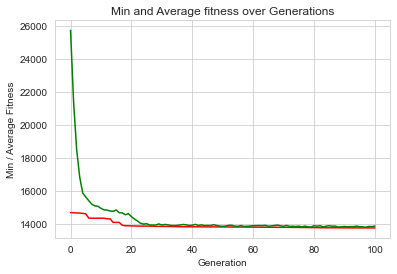

In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import  GradientBoostingRegressor

#============================== СБОРКА ДАТАСЕТА ==============================#

def parser(a):
    b = pd.read_csv(f'{a}.csv',sep=';')
    return b

eurusd = parser('EURUSD')
cot0 = parser('data')
cot0 = cot0.merge(eurusd,how = 'inner')
cot0 = cot0.dropna(axis=0)
cot1 = cot0.drop(['Date'], axis = 1)

cot2 = cot1.copy()
cot1=cot1.to_numpy()

y =  cot2['Open_Interest'].to_numpy()

x = cot2.to_numpy()
y = y[1:]
x = x[:-1]
x = pd.DataFrame(data=x)

def find_index(data, percent_test, percent_val):
    val_index = int(len(data) - len(data)*percent_test/100)
    train_index = int(val_index - val_index*percent_val/100)
    return train_index, val_index

cot=cot1.copy()
tr_index, val_index = find_index(cot,8.8,12.9)
print(len(cot),":",tr_index,val_index-tr_index,len(cot)-val_index) # Чтобы полтора года на тест и два года на валидацию

#============================== КЛАСС С МОДЕЛЬЮ ==============================# 

class Model:
    
    def __init__(self,x,y,tr_index,val_index,randomseed):
        self.randomseed=randomseed
        self.tr_index = tr_index
        self.val_index = val_index
        self.x=x
        self.y=y
        
    def __len__(self):
        return self.x.shape[1]

    def getMAE(self,chromosome):
        
        columns_raw=[]
        for i in chromosome[:14]:
            columns_raw.append(round(i))
        zero_columns = [i for i, n in enumerate(columns_raw) if n == 0]
        current_x = self.x.drop(self.x.columns[zero_columns], axis=1)
        current_x = current_x.to_numpy()

        x_train = current_x[:self.tr_index+1]
        y_train = self.y[:self.tr_index+1]
        
        x_val = current_x[self.tr_index+1:self.val_index+1]
        y_val = self.y[self.tr_index+1:self.val_index+1]
        
        parameters = chromosome[14:]
        parameters[0]=round(parameters[0])
        parameters[1]=round(parameters[1])
        regressor = GradientBoostingRegressor(random_state=self.randomseed,
                                                n_estimators = parameters[0],
                                                max_depth = parameters[1],
                                                learning_rate = parameters[2],
                                                loss = 'squared_error')
        regressor.fit(x_train, y_train)
        return np.mean(abs(regressor.predict(x_val)-y_val))

#============================== ГЕНЕТИКА ==============================# 
from deap import base
from deap import creator
from deap import tools
import random
import matplotlib.pyplot as plt
import seaborn as sns
import elitism

POPULATION_SIZE = 100        
P_CROSSOVER = 0.9            
P_MUTATION = 0.3             
MAX_GENERATIONS = 100     
HALL_OF_FAME_SIZE = 10       
FEATURE_PENALTY_FACTOR = 50   
RANDOM_SEED = 43           
CROWDING_FACTOR = 20.0       
random.seed(RANDOM_SEED)
BOUNDS_HIGH = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,250,10,1]
BOUNDS_LOW = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.01]
NUM_OF_PARAMS = len(BOUNDS_HIGH)

model = Model(x,y,tr_index,val_index,RANDOM_SEED)

toolbox = base.Toolbox()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

for i in range(NUM_OF_PARAMS):
    # "hyperparameter_0", "hyperparameter_1", ...
    toolbox.register("hyperparameter_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])
hyperparameters = ()
for i in range(NUM_OF_PARAMS):
    hyperparameters = hyperparameters + (toolbox.__getattribute__("hyperparameter_" + str(i)),)

toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 hyperparameters,
                 n=1)

toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

def calculating_mae(individual):
    numFeaturesUsed = sum(individual[:14])
    if numFeaturesUsed == 0:
        return 100000
    else:
        mae = model.getMAE(individual)
        return mae + FEATURE_PENALTY_FACTOR * numFeaturesUsed,  
    
toolbox.register("evaluate", calculating_mae)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0 / NUM_OF_PARAMS)

population = toolbox.populationCreator(n=POPULATION_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook = elitism.eaSimpleWithElitism(population, 
                                                  toolbox, 
                                                  cxpb=P_CROSSOVER, 
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS, 
                                                  stats=stats,
                                                  halloffame=hof, 
                                                  verbose=True)
print("Best solutions are:")
for i in range(HALL_OF_FAME_SIZE):
    print(i, ": ", hof.items[i], ", fitness = ", hof.items[i].fitness.values[0],
          ", Squared_error = ", model.getMAE(hof.items[i]))

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')
plt.show()

In [5]:
reserv_data = pd.DataFrame(logbook)
reserv_data.to_csv('Резерв 6 данные')
reserv_hof = pd.DataFrame(hof)
reserv_hof.to_csv('Резерв 6 зал славы')

In [ ]:
#============================== ТЕСТ КОНЕЧНОЙ МОДЕЛИ ==============================# 
import numpy as np
import pandas as pd
from sklearn.ensemble import  GradientBoostingRegressor

def parser(a):
    b = pd.read_csv(f'{a}.csv',sep=';')
    return b

eurusd = parser('EURUSD')
cot0 = parser('data')
cot0 = cot0.merge(eurusd,how = 'inner')
cot0 = cot0.dropna(axis=0)
cot1 = cot0.drop(['Date'], axis = 1)

cot2 = cot1.copy()

y =  cot2['Open_Interest'].to_numpy()

x = cot2.to_numpy()
y = y[1:]
x = x[:-1]

x=x[:,[4,5,9,13]]  

def find_index(data, percent_test, percent_val):
    val_index = int(len(data) - len(data)*percent_test/100)
    train_index = int(val_index - val_index*percent_val/100)
    return train_index, val_index

cot=cot1.copy()
tr_index, val_index = find_index(cot,8.8,12.9)

regressor = GradientBoostingRegressor(random_state = 43, 
                                                n_estimators = 141,        
                                                max_depth = 2,             
                                                learning_rate = 0.473524796871654,    
                                                loss = 'squared_error')
x_train = x[:val_index+1]
y_train = y[:val_index+1]
x_test = x[val_index+1:]
y_test = y[val_index+1:]
    
regressor.fit(x_train,y_train)
print(np.mean(abs(regressor.predict(x_test)-y_test)))
print(np.mean(abs(x_test[:,0]-y_test)))
print(np.mean(abs(x[tr_index+1:val_index+1][:,0]-y[tr_index+1:val_index+1])))

preds = regressor.predict(x_test)
real = y_test
naiv = x_test[:,0]

data = pd.DataFrame({'preds':preds,
                    'real':real,
                    'naiv':naiv})
data.to_csv('predictions',sep=';')

[0,4,11],240,2,0.3783 - 12827.78224438212 
[4,5,9,13],269,3,0.579565 - 13043.276900551407
[4,5,9,11,13],100,2,0.8264 - 13725.480791212263
[4,5,9,13], 141, 2, 0.473524796871654 - 12609.77452010969

# Химельблау

816 : 648 96 72


C:\PROGRAMMS\PYTHON\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\PROGRAMMS\PYTHON\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    	avg    
0  	100   	14054.3	21959.5
1  	83    	14054.3	20225.3
2  	85    	14038.2	19650.2
3  	84    	13809.1	17421.8
4  	81    	13809.1	17066.5
5  	85    	13809.1	15561.2
6  	85    	13809.1	15019.1
7  	86    	13809.1	14717.9
8  	82    	13809.1	14722.2
9  	86    	13809.1	14534.1
10 	81    	13809.1	14380.2
11 	85    	13809.1	14492.3
12 	88    	13809.1	14402.4
13 	80    	13809.1	14340.2
14 	85    	13793.3	14513.3
15 	83    	13792.7	14432.4
16 	84    	13718.2	14447.1
17 	80    	13317  	14413.1
18 	80    	13317  	14179.8
19 	86    	13317  	14121.4
20 	83    	13317  	14071.7
21 	85    	13316.6	14050.2
22 	86    	13316.6	13959.2
23 	82    	13193.3	14231.3
24 	83    	13193.3	14272.3
25 	80    	13183.6	14255.1
26 	80    	13171.5	14371.1
27 	83    	13111.1	13937.6
28 	79    	13109.6	13759  
29 	90    	13109.6	13765.6
30 	85    	13102.9	13551.5
31 	89    	13102.9	13762.9
32 	86    	13102.9	13815.3
33 	85    	13090  	13871  
34 	83    	13090  	13804  
35 	82    	13081.5	13484.8
3

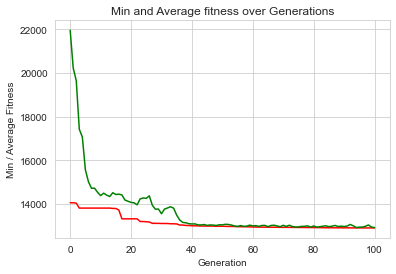

In [21]:
import numpy as np
import pandas as pd
from sklearn.ensemble import  GradientBoostingRegressor
import math

#============================== СБОРКА ДАТАСЕТА ==============================#

def parser(a):
    b = pd.read_csv(f'{a}.csv',sep=';')
    return b

eurusd = parser('EURUSD')
cot0 = parser('data')
cot0 = cot0.merge(eurusd,how = 'inner')
cot0 = cot0.dropna(axis=0)
cot1 = cot0.drop(['Date'], axis = 1)

cot2 = cot1.copy()
cot1=cot1.to_numpy()

y =  cot2['Open_Interest'].to_numpy()

x = cot2.to_numpy()
y = y[1:]
x = x[:-1]
x = pd.DataFrame(data=x)

def find_index(data, percent_test, percent_val):
    val_index = int(len(data) - len(data)*percent_test/100)
    train_index = int(val_index - val_index*percent_val/100)
    return train_index, val_index

cot=cot1.copy()
tr_index, val_index = find_index(cot,8.8,12.9)
print(len(cot),":",tr_index,val_index-tr_index,len(cot)-val_index) # Чтобы полтора года на тест и два года на валидацию

#============================== КЛАСС С МОДЕЛЬЮ ==============================# 

class Model:
    
    def __init__(self,x,y,tr_index,val_index,randomseed):
        self.randomseed=randomseed
        self.tr_index = tr_index
        self.val_index = val_index
        self.x=x
        self.y=y
        
    def __len__(self):
        return self.x.shape[1]

    def getMAE(self,chromosome):
        
        columns_raw=[]
        for i in chromosome[:14]:
            columns_raw.append(round(i))
        zero_columns = [i for i, n in enumerate(columns_raw) if n == 0]
        current_x = self.x.drop(self.x.columns[zero_columns], axis=1)
        current_x = current_x.to_numpy()

        x_train = current_x[:self.tr_index+1]
        y_train = self.y[:self.tr_index+1]
        
        x_val = current_x[self.tr_index+1:self.val_index+1]
        y_val = self.y[self.tr_index+1:self.val_index+1]
        
        parameters = chromosome[14:]
        parameters[0]=round(parameters[0])
        parameters[1]=round(parameters[1])
        regressor = GradientBoostingRegressor(random_state=self.randomseed,
                                                n_estimators = parameters[0],
                                                max_depth = parameters[1],
                                                learning_rate = parameters[2],
                                                loss = 'lad')
        regressor.fit(x_train, y_train)
        return np.mean(abs(regressor.predict(x_val)-y_val))

#============================== ГЕНЕТИКА ==============================# 
from deap import base
from deap import creator
from deap import tools
import random
import matplotlib.pyplot as plt
import seaborn as sns
import elitism

POPULATION_SIZE = 100        
P_CROSSOVER = 0.9            
P_MUTATION = 0.3             
MAX_GENERATIONS = 100       
HALL_OF_FAME_SIZE = 10       
FEATURE_PENALTY_FACTOR = 50   
RANDOM_SEED = 43             
CROWDING_FACTOR = 20.0        
random.seed(RANDOM_SEED)
BOUNDS_HIGH = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,250,10,1]
BOUNDS_LOW = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.01]
NUM_OF_PARAMS = len(BOUNDS_HIGH)


# ======================================================================================================================
DISTANCE_THRESHOLD = 0.05
SHARING_EXTENT = 100.0
# ======================================================================================================================


model = Model(x,y,tr_index,val_index,RANDOM_SEED)

toolbox = base.Toolbox()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

for i in range(NUM_OF_PARAMS):
    # "hyperparameter_0", "hyperparameter_1", ...
    toolbox.register("hyperparameter_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])
hyperparameters = ()
for i in range(NUM_OF_PARAMS):
    hyperparameters = hyperparameters + (toolbox.__getattribute__("hyperparameter_" + str(i)),)

toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 hyperparameters,
                 n=1)

toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

def calculating_mae(individual):
    numFeaturesUsed = sum(individual[:14])
    if numFeaturesUsed == 0:
        return 100000
    else:
        mae = model.getMAE(individual)
        return mae + FEATURE_PENALTY_FACTOR * numFeaturesUsed,  
    
toolbox.register("evaluate", calculating_mae)

# ======================================================================================================================
def selTournamentWithSharing(individuals, k, tournsize, fit_attr="fitness"):

    # get orig fitnesses:
    origFitnesses = [ind.fitness.values[0] for ind in individuals]

    # apply sharing to each individual:
    for i in range(len(individuals)):
        sharingSum = 1

        # iterate over all other individuals
        for j in range(len(individuals)):
            if i != j:
                # calculate eucledean distance between individuals:
                distance = math.sqrt(
                    ((individuals[i][0] - individuals[j][0]) ** 2) + ((individuals[i][1] - individuals[j][1]) ** 2))

                if distance < DISTANCE_THRESHOLD:
                    sharingSum += (1 - distance / (SHARING_EXTENT * DISTANCE_THRESHOLD))

        # reduce fitness accordingly:
        individuals[i].fitness.values = origFitnesses[i] / sharingSum,

    # apply original tools.selTournament() using modified fitness:
    selected = tools.selTournament(individuals, k, tournsize, fit_attr)

    # retrieve original fitness:
    for i, ind in enumerate(individuals):
        ind.fitness.values = origFitnesses[i],

    return selected
# ======================================================================================================================

toolbox.register("select", selTournamentWithSharing, tournsize=2)
toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0 / NUM_OF_PARAMS)

population = toolbox.populationCreator(n=POPULATION_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook = elitism.eaSimpleWithElitism(population, 
                                                  toolbox, 
                                                  cxpb=P_CROSSOVER, 
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS, 
                                                  stats=stats,
                                                  halloffame=hof, 
                                                  verbose=True)
print("Best solutions are:")
for i in range(HALL_OF_FAME_SIZE):
    print(i, ": ", hof.items[i], ", fitness = ", hof.items[i].fitness.values[0],
          ", MAE = ", model.getMAE(hof.items[i]))

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')
plt.show()

In [19]:
reserv_data = pd.DataFrame(logbook)
reserv_data.to_csv('Хим. Резерв 0 данные')
reserv_hof = pd.DataFrame(hof)
reserv_hof.to_csv('Хим. Резерв 0 зал славы')

In [20]:
#============================== ТЕСТ КОНЕЧНОЙ МОДЕЛИ ==============================# 
import numpy as np
import pandas as pd
from sklearn.ensemble import  GradientBoostingRegressor

def parser(a):
    b = pd.read_csv(f'{a}.csv',sep=';')
    return b

eurusd = parser('EURUSD')
cot0 = parser('data')
cot0 = cot0.merge(eurusd,how = 'inner')
cot0 = cot0.dropna(axis=0)
cot1 = cot0.drop(['Date'], axis = 1)

cot2 = cot1.copy()

y =  cot2['Open_Interest'].to_numpy()

x = cot2.to_numpy()
y = y[1:]
x = x[:-1]

x=x[:,[4,5,9,11,13]]  

def find_index(data, percent_test, percent_val):
    val_index = int(len(data) - len(data)*percent_test/100)
    train_index = int(val_index - val_index*percent_val/100)
    return train_index, val_index

cot=cot1.copy()
tr_index, val_index = find_index(cot,8.8,12.9)

regressor = GradientBoostingRegressor(random_state = 43, 
                                                n_estimators = 56,        
                                                max_depth = 4,             
                                                learning_rate = 0.38744200070662993,    
                                                loss = 'lad')
x_train = x[:val_index+1]
y_train = y[:val_index+1]
x_test = x[val_index+1:]
y_test = y[val_index+1:]
    
regressor.fit(x_train,y_train)
print(np.mean(abs(regressor.predict(x_test)-y_test)))
print(np.mean(abs(x_test[:,0]-y_test)))
print(np.mean(abs(x[tr_index+1:val_index+1][:,0]-y[tr_index+1:val_index+1])))

13190.374052362587
17125.928571428572
24134.010416666668
